Cell 1: Imports and Setup

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging

# Configure logging for debugging and info
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Download NLTK data (only run once)
download('punkt')
download('stopwords')


[nltk_data] Downloading package punkt to /home/sam2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sam2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Cell 2: Define the FinancialNewsEDA class

In [8]:
class FinancialNewsEDA:
    """
    A class encapsulating Exploratory Data Analysis operations
    for financial news datasets.
    """

    def __init__(self, data: pd.DataFrame):
        """
        Initialize with a raw pandas DataFrame.
        """
        self.df = data.copy()
        self.stop_words = set(stopwords.words('english'))
        self.cleaned = False  # Flag to track if cleaning done

    def clean_data(self, output_path: str):
        """
        Clean data by removing duplicates, missing values, and formatting dates.
        Saves cleaned data to CSV.
        """
        try:
            if 'Unnamed: 0' in self.df.columns:
                self.df.drop(columns=['Unnamed: 0'], inplace=True)
            self.df.drop_duplicates(inplace=True)
            self.df.dropna(subset=['headline', 'publisher', 'date'], inplace=True)
            self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
            self.df.dropna(subset=['date'], inplace=True)

            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            self.df.to_csv(output_path, index=False)

            self.cleaned = True
            logging.info(f"Data cleaned and saved to {output_path}. Shape: {self.df.shape}")

        except Exception as e:
            logging.error(f"Error in clean_data(): {e}")
            raise

    def descriptive_statistics(self):
        """
        Calculate and plot headline lengths and publisher counts.
        """
        if not self.cleaned:
            logging.warning("Call clean_data() before descriptive_statistics().")
            return

        try:
            self.df['headline_length'] = self.df['headline'].apply(len)
            logging.info("Headline Length Description:\n" + str(self.df['headline_length'].describe()))

            publisher_counts = self.df['publisher'].value_counts()
            logging.info("Top Publishers by Article Count:\n" + str(publisher_counts.head()))

            plt.figure(figsize=(10,6))
            publisher_counts.head(10).plot(kind='bar', color='skyblue')
            plt.title('Top 10 Publishers by Article Count')
            plt.xlabel('Publisher')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(f"Error in descriptive_statistics(): {e}")
            raise

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess text for topic modeling: lowercase, remove punctuation, tokenize, remove stopwords.
        """
        try:
            text = re.sub(r'[^\w\s]', '', text.lower())
            tokens = word_tokenize(text)
            filtered_tokens = [w for w in tokens if w not in self.stop_words and len(w) > 3]
            return ' '.join(filtered_tokens)
        except Exception as e:
            logging.error(f"Error in preprocess_text(): {e}")
            return ""

    def topic_modeling(self, n_topics: int = 5):
        """
        Perform LDA topic modeling on cleaned headlines.
        """
        if not self.cleaned:
            logging.warning("Call clean_data() before topic_modeling().")
            return

        try:
            self.df['cleaned_headline'] = self.df['headline'].apply(self.preprocess_text)
            vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
            tfidf_matrix = vectorizer.fit_transform(self.df['cleaned_headline'])
            feature_names = vectorizer.get_feature_names_out()

            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda.fit(tfidf_matrix)

            logging.info("LDA Topics:")
            for idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:]]
                logging.info(f"Topic {idx + 1}: {', '.join(top_words)}")

        except Exception as e:
            logging.error(f"Error in topic_modeling(): {e}")
            raise

    def time_series_analysis(self):
        """
        Analyze and plot frequency of articles over time by day and hour.
        """
        if not self.cleaned:
            logging.warning("Call clean_data() before time_series_analysis().")
            return

        try:
            self.df['date_only'] = self.df['date'].dt.date
            self.df['hour'] = self.df['date'].dt.hour

            daily_counts = self.df['date_only'].value_counts().sort_index()
            logging.info("Daily Publication Frequency:\n" + str(daily_counts.head()))

            plt.figure(figsize=(12,6))
            daily_counts.plot(kind='line', color='teal')
            plt.title('Daily Publication Frequency')
            plt.xlabel('Date')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            hourly_counts = self.df['hour'].value_counts().sort_index()
            logging.info("Hourly Publication Frequency:\n" + str(hourly_counts))

            plt.figure(figsize=(10,6))
            hourly_counts.plot(kind='bar', color='coral')
            plt.title('Hourly Publication Frequency')
            plt.xlabel('Hour of Day')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(f"Error in time_series_analysis(): {e}")
            raise

    def publisher_analysis(self):
        """
        Analyze publisher distribution and extract domains.
        """
        if not self.cleaned:
            logging.warning("Call clean_data() before publisher_analysis().")
            return

        try:
            publisher_counts = self.df['publisher'].value_counts()
            logging.info("Publisher Counts:\n" + str(publisher_counts.head()))

            def extract_domain(publisher):
                return publisher.split('@')[-1] if '@' in publisher else publisher

            self.df['domain'] = self.df['publisher'].apply(extract_domain)
            domain_counts = self.df['domain'].value_counts()
            logging.info("Top Domains:\n" + str(domain_counts.head()))

            plt.figure(figsize=(10,6))
            domain_counts.head(10).plot(kind='bar', color='lightgreen')
            plt.title('Top 10 Domains by Article Count')
            plt.xlabel('Domain')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(f"Error in publisher_analysis(): {e}")
            raise


Exploratory Data Analysis (EDA)

INFO: Data cleaned and saved to ../data/cleaned_financial_news.csv. Shape: (55987, 5)
INFO: Headline Length Description:
count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64
INFO: Top Publishers by Article Count:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Name: count, dtype: int64


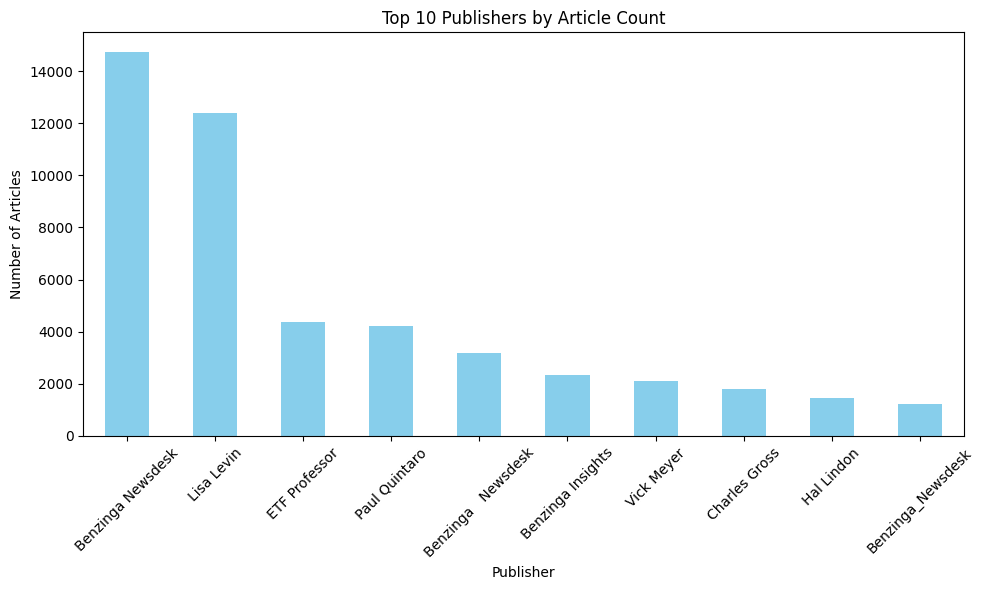

INFO: LDA Topics:
INFO: Topic 1: midday, premarket, tuesdays, stocks, wednesdays, upgrades, downgrades, session, moving, benzingas
INFO: Topic 2: economic, amid, higher, shares, trading, several, companies, yesterday, movers, biggest
INFO: Topic 3: lower, results, miss, beat, beats, market, update, shares, sales, estimate
INFO: Topic 4: reports, trading, announces, watch, 2020, dividend, scheduled, etfs, earnings, 2018
INFO: Topic 5: wednesday, maintains, friday, price, target, thursday, highs, lows, stocks, 52week
INFO: Daily Publication Frequency:
date_only
2011-04-27    1
2011-04-28    2
2011-04-29    2
2011-04-30    1
2011-05-01    1
Name: count, dtype: int64


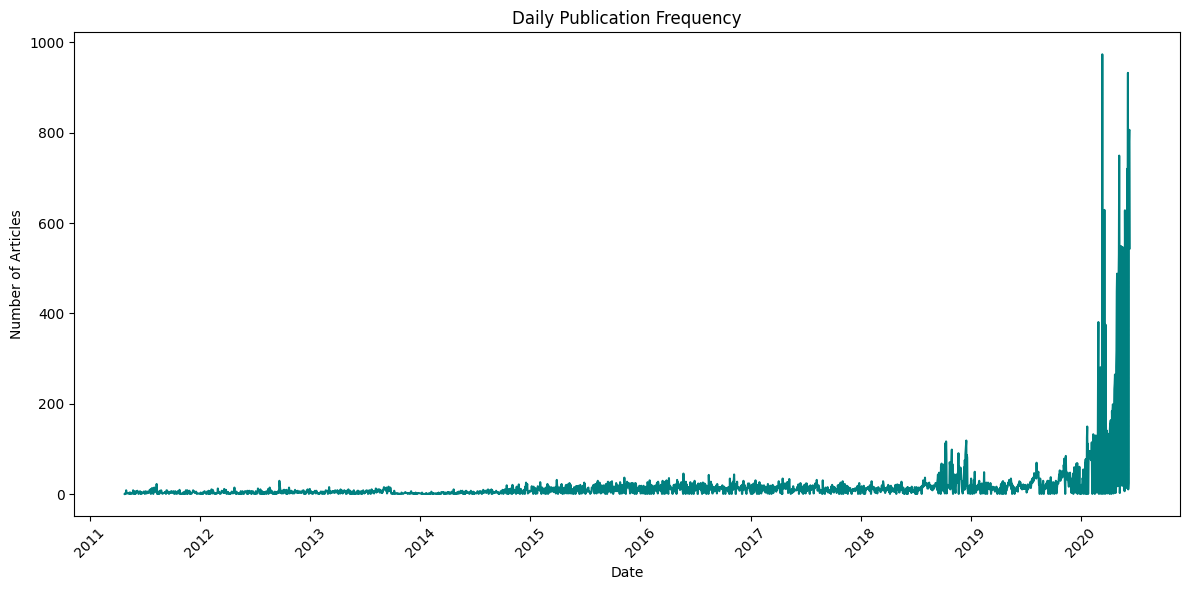

INFO: Hourly Publication Frequency:
hour
0       67
1       14
2       57
3       93
4     1469
5     1829
6     2476
7     5033
8     5527
9     5965
10    7669
11    5701
12    5732
13    2710
14    2075
15    1612
16    3939
17    2800
18     704
19     227
20     131
21      82
22      48
23      27
Name: count, dtype: int64


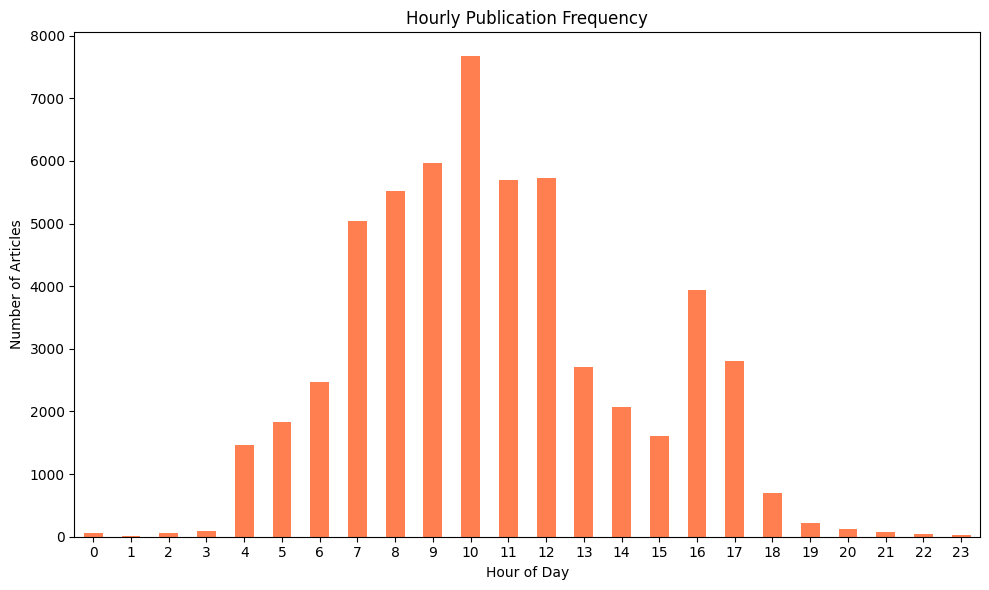

INFO: Publisher Counts:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Name: count, dtype: int64
INFO: Top Domains:
domain
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Name: count, dtype: int64


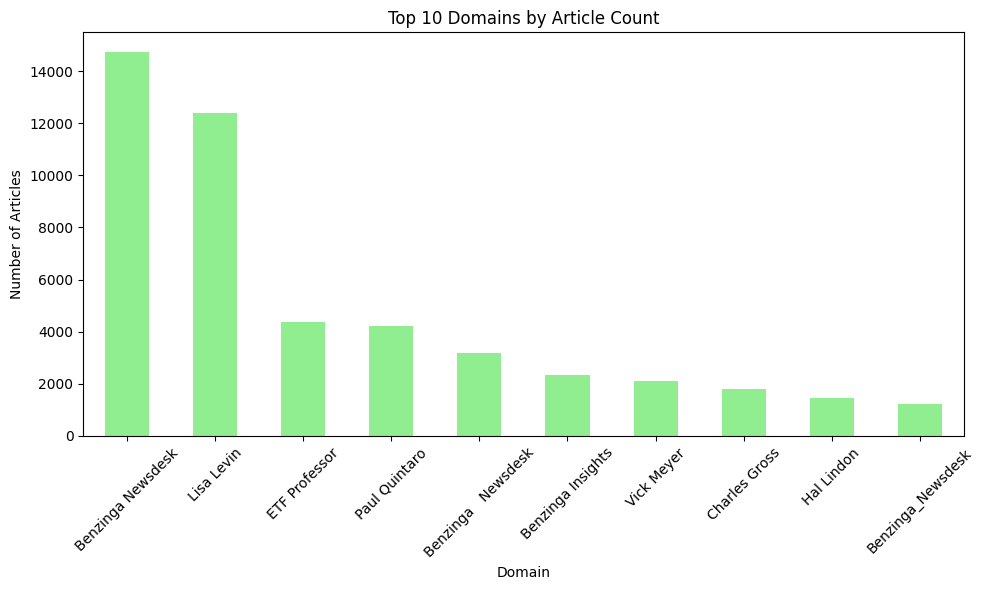

In [11]:
# Load your raw data (replace with your actual path)
raw_data = pd.read_csv('../data/raw_analyst_ratings.csv')

# Create an instance of FinancialNewsEDA
eda = FinancialNewsEDA(raw_data)

# Clean the data and save to CSV
eda.clean_data('../data/cleaned_financial_news.csv')

# Run descriptive statistics analysis
eda.descriptive_statistics()

# Run topic modeling
eda.topic_modeling(n_topics=5)

# Run time series analysis
eda.time_series_analysis()

# Run publisher analysis
eda.publisher_analysis()
